In [1]:
import os, sys
import glob
import zipfile
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer
import IPython.display as display
from matplotlib import animation


torch.cuda.is_available()

True

In [2]:
##custom transformation to encode images in spikes
class To_spikes(object):
    def __init__(self,time_steps, vth, img_H, img_W=None): ##return a np.array of (HxW,timesteps)
        if img_W==None:
            img_W=img_H
        self.shape = img_H*img_W
        self.vth =vth
        self.time_steps = time_steps

        self.v=np.zeros((self.shape,))

    def __call__(self, sample):
        
        out =[]
        sample = np.array(sample,dtype=np.int32)
        sample = sample -127
        sample = np.reshape(sample, (self.shape,))
        for i in range(self.time_steps):
           
            self.v = self.v + sample
            tmp = self.v > self.vth
            self.v[tmp] = 0

            if i==0:
                out=np.array([tmp])
            else:
                out=np.vstack((out,tmp))
        
        self.v[:] = 0
        
        return out.T.astype(np.float32)


class squeeze_Tensor(object):
    
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, sample):
        return sample.squeeze(self.dim)

In [3]:
transformation = transforms.Compose([To_spikes(128, 1, 28),transforms.ToTensor(), squeeze_Tensor(0)])
training_set = datasets.MNIST(root='./data', train=True, download=True, transform=transformation)
testing_set  = datasets.MNIST(root='./data', train=False, download=True, transform=transformation)

train_loader = DataLoader(dataset=training_set, batch_size=32, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=32, shuffle=True)

In [4]:
"""
training_set = datasets.MNIST(root='./data', train=True, download=True, )
testing_set  = datasets.MNIST(root='./data', train=False, download=True,)

train_loader = DataLoader(dataset=training_set, batch_size=32, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=32, shuffle=True)"""

"\ntraining_set = datasets.MNIST(root='./data', train=True, download=True, )\ntesting_set  = datasets.MNIST(root='./data', train=False, download=True,)\n\ntrain_loader = DataLoader(dataset=training_set, batch_size=32, shuffle=True)\ntest_loader  = DataLoader(dataset=testing_set , batch_size=32, shuffle=True)"

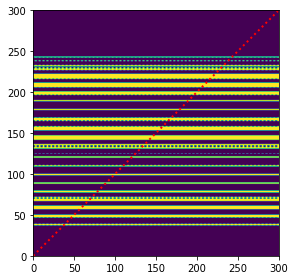

In [ ]:
img, label = testing_set[np.random.randint(len(testing_set))]
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
im = ax.imshow(img, extent=[0, 300, 0, 300])
x = np.array(range(300))
ax.plot(x, x, ls='dotted', linewidth=2, color='red')
plt.show()


In [11]:
os.makedirs('gifs', exist_ok=True)

for i in range(5):
    spike_tensor, label = testing_set[np.random.randint(len(testing_set))]
    print(spike_tensor.size())
    spike_tensor = spike_tensor.reshape(1, 28, 28, -1)
    print(spike_tensor.size())
    event = slayer.io.tensor_to_event(spike_tensor.cpu().data.numpy())
    anim = event.anim(plt.figure(figsize=(5, 5)), frame_rate=60)
    anim.save(f'./gifs/input{i}.gif', animation.PillowWriter(fps=24), dpi=300)

torch.Size([784, 128])
torch.Size([1, 28, 28, 128])
torch.Size([784, 128])
torch.Size([1, 28, 28, 128])
torch.Size([784, 128])
torch.Size([1, 28, 28, 128])
torch.Size([784, 128])
torch.Size([1, 28, 28, 128])
torch.Size([784, 128])
torch.Size([1, 28, 28, 128])


In [12]:

gif_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 250px;"/> </td>'
header = '<table><tr>'
images = ' '.join([gif_td(f'./gifs/input{i}.gif') for i in range(5)])
footer = '</tr></table>'
display.HTML(header + images + footer)

,,,,


In [13]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,     
            }
        neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}
        
        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params_drop, 784, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params_drop, 512, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 512, 10, weight_norm=True),
            ])
    
    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike
    
    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

In [16]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

#device = torch.device('cpu')
device = torch.device('cuda') 

net = Network().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device)
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

In [17]:
epochs = 30

for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader): # training loop
        output = assistant.train(input, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    for i, (input, label) in enumerate(test_loader): # training loop
        output = assistant.test(input, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    if epoch%20 == 19: # cleanup display
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        stats_str = str(stats).replace("| ", "\n")
        print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')
    
    if stats.testing.best_accuracy:
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    net.grad_flow(trained_folder + '/')

                                                                                                                                                                                       
[Epoch 19/30]
Train loss =     0.23576 (min =     0.23107)    accuracy = 0.96567 (max = 0.96730) 
Test  loss =     0.22121 (min =     0.19194)    accuracy = 0.95500 (max = 0.95980)
[Epoch 29/30] Train loss =     0.21757 (min =     0.22146)    accuracy = 0.97390 (max = 0.97158) | Test  loss =     0.20716 (min =     0.19194)    accuracy = 0.95680 (max = 0.95980)

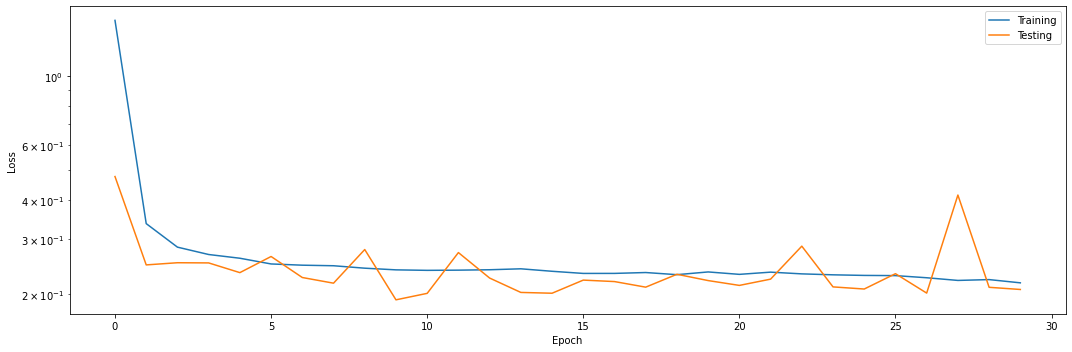

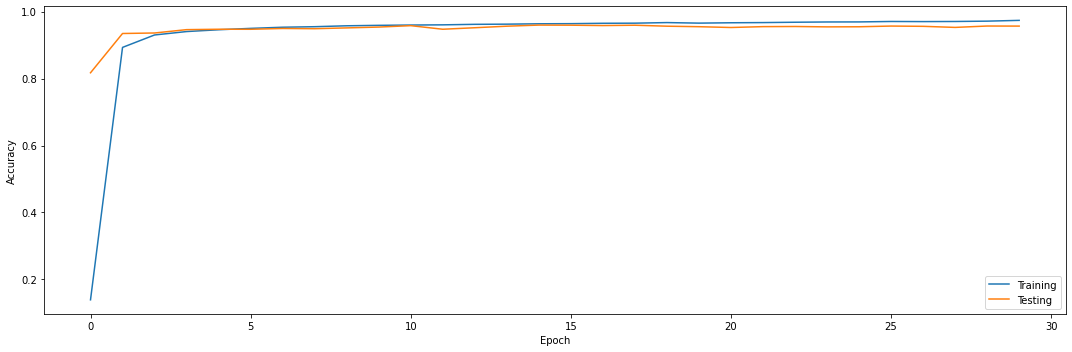

In [18]:
stats.plot(figsize=(15, 5))

In [19]:
net.load_state_dict(torch.load(trained_folder + '/network.pt'))
net.export_hdf5(trained_folder + '/network.net')

In [20]:
output = net(input.to(device))
for i in range(5):
    inp_event = slayer.io.tensor_to_event(input[i].cpu().data.numpy().reshape(1, 28, 28, -1))
    out_event = slayer.io.tensor_to_event(output[i].cpu().data.numpy().reshape(1, 10, -1))
    inp_anim = inp_event.anim(plt.figure(figsize=(5, 5)), frame_rate=60)
    out_anim = out_event.anim(plt.figure(figsize=(10, 5)), frame_rate=60)
    inp_anim.save(f'gifs/inp{i}.gif', animation.PillowWriter(fps=24), dpi=300)
    out_anim.save(f'gifs/out{i}.gif', animation.PillowWriter(fps=24), dpi=300)


In [21]:
gif_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 250px;"/> </td>'
html = '<table>'
html += '<tr><td align="center"><b>Input</b></td><td><b>Output</b></td></tr>'
for i in range(5):
    html += '<tr>'
    html += gif_td(f'gifs/inp{i}.gif')
    html += gif_td(f'gifs/out{i}.gif')
    html += '</tr>'
html += '</tr></table>'
display.HTML(html)

#WTA Layer output

Input,Output
,
,
,
,
,
